In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riya016","key":"b968ba9d119ce7f425910f20e2e8f823"}'}

In [ ]:
import os
import shutil

# Make the .kaggle directory and move kaggle.json
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/')

# Set correct permissions
os.chmod('/root/.kaggle/kaggle.json', 600)


In [ ]:
!kaggle datasets download -d shubham2703/five-crop-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/shubham2703/five-crop-diseases-dataset
License(s): CC-BY-NC-SA-4.0
100% 4.33G/4.33G [03:03<00:00, 23.7MB/s]
100% 4.33G/4.33G [03:03<00:00, 25.3MB/s]


In [ ]:
!unzip five-crop-diseases-dataset.zip -d five_crop_diseases


Streaming output truncated to the last 5000 lines.
  inflating: five_crop_diseases/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125251.jpg  
  inflating: five_crop_diseases/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125403.jpg  
  inflating: five_crop_diseases/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125426.jpg  
  inflating: five_crop_diseases/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125429.jpg  
  inflating: five_crop_diseases/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125436.jpg  
  inflating: five_crop_diseases/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125441.jpg  
  inflating: five_crop_diseases/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125504.jpg  
  inflating: five_crop_di

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os

In [ ]:
directory_path = r'five_crop_diseases/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Corn'

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle="True",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 3852 files belonging to 4 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Northern_Leaf_Blight']

In [ ]:
len(dataset)


121

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(32, 256, 256, 3)
[2 0 2 0 1 0 1 0 1 0 0 0 3 3 3 2 1 3 0 1 1 0 1 2 3 3 3 2 3 0 2 0]


In [ ]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.08, test_split=0.12, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(dataset)

    if shuffle:
        daaset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset


In [ ]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

96
9
16


In [ ]:
from tensorflow.keras import models, layers
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(256, 256),
  layers.Rescaling(1./255),
])
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)


(32, 256, 256, 3) (32,)


# **EfficientNetB0**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model

# Input layer
input_layer = layers.Input(shape=(256, 256, 3), name="input")

# Load EfficientNetB0 without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze layers if you don't want to retrain
base_model.trainable = False

# Add custom layers
x = base_model.output
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.GlobalAveragePooling2D()(x)
output_layer = layers.Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Model summary
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_2[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 7,005,095 (26.72 MB)

 Trainable params: 2,952,964 (11.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
for images, labels in train_dataset.take(1):
    print("Image shape:", images.shape)  # Expected: (BATCH_SIZE, 224, 224, 3)
    print("Label shape:", labels.shape)   # Expected: (BATCH_SIZE,) for sparse_categorical_crossentropy

# Train the model
try:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=30,
        verbose=1
    )
except Exception as e:
    print("Error during training:", e)

Image shape: (32, 256, 256, 3)
Label shape: (32,)
Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9913 - loss: 0.0323 - val_accuracy: 0.9792 - val_loss: 0.1164
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9910 - loss: 0.0394 - val_accuracy: 0.9757 - val_loss: 0.0961
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9861 - val_loss: 0.1357
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9953 - loss: 0.0127 - val_accuracy: 0.9896 - val_loss: 0.0775
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9978 - loss: 0.0047 - val_accuracy: 0.9826 - val_loss: 0.1073
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9896 - val_loss: 0.0475
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9963 - loss: 0.0092 - val_accuracy: 0.9792 - val_loss: 0.1066
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy

In [ ]:
model.evaluate(test_dataset)


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - accuracy: 0.9873 - loss: 0.1079


[0.16683197021484375, 0.9817073345184326]

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    # Plot loss
    plt.figure(figsize=(12, 5))  # Optional: Set figure size
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')

    # Set y-axis limits for accuracy plot
    plt.ylim(0.76, 0.99)  # Set limits from 76 to 99

    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

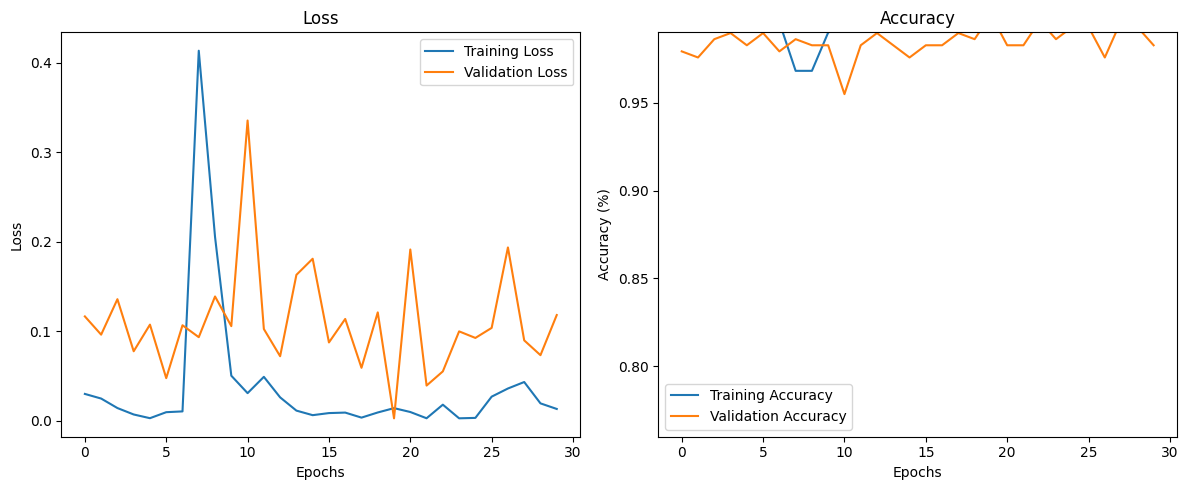

In [ ]:
plot_loss_curves(history)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import tensorflow as tf

# Assuming you have a trained model and test_dataset
# You need to get the true labels and predicted labels from the test set

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  # Assuming labels are in a tensor format
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert softmax outputs to class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the classification report (precision, recall, F1-score)
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

# Calculate accuracy using sklearn
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9922 - loss: 0.0854
Test Loss: 0.1273886263370514
Test Accuracy: 0.9878048896789551
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Confusion Matrix:
[[153   0   0   0]
 [  0  71   0   1]
 [  0   0 148   0]
 [  0   7   0 112]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       0.91 

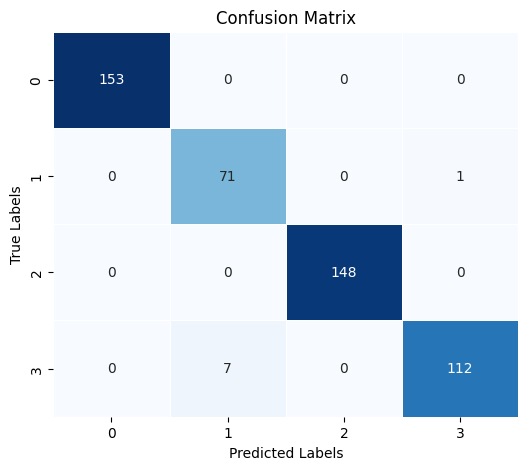

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define confusion matrix
conf_matrix = np.array([[153, 0, 0, 0],
                        [0, 71, 0, 1],
                        [0, 0, 148, 0],
                        [0, 7, 0, 112]])

# Create heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()


# **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)
base_model.trainable = False  # Freeze layers

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
output_layer = layers.Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)


NameError: name 'input_layer' is not defined

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,0

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
for images, labels in train_dataset.take(1):
    print("Image shape:", images.shape)  # Expected: (BATCH_SIZE, 224, 224, 3)
    print("Label shape:", labels.shape)   # Expected: (BATCH_SIZE,) for sparse_categorical_crossentropy

# Train the model
try:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=30,
        verbose=1
    )
except Exception as e:
    print("Error during training:", e)

Image shape: (32, 256, 256, 3)
Label shape: (32,)
Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 258ms/step - accuracy: 0.5478 - loss: 2.1920 - val_accuracy: 0.9236 - val_loss: 0.2684
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.8834 - loss: 0.3350 - val_accuracy: 0.9340 - val_loss: 0.2162
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 272ms/step - accuracy: 0.9191 - loss: 0.2276 - val_accuracy: 0.9410 - val_loss: 0.1457
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 0.9326 - loss: 0.1769 - val_accuracy: 0.9757 - val_loss: 0.1081
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.9523 - loss: 0.1476 - val_accuracy: 0.9653 - val_loss: 0.1090
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - accuracy: 0.9577 - loss: 0.1292 - val_accuracy: 0.9410 - val_loss: 0.1570
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.9613 - loss: 0.1127 - val_accuracy: 0.9583 - val_loss: 0.1213
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms

In [ ]:
model.evaluate(test_dataset)


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 737ms/step - accuracy: 0.9598 - loss: 0.0951


[0.09187203645706177, 0.9654471278190613]

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    # Plot loss
    plt.figure(figsize=(12, 5))  # Optional: Set figure size
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')

    # Set y-axis limits for accuracy plot
    plt.ylim(0.76, 0.99)  # Set limits from 76 to 99

    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

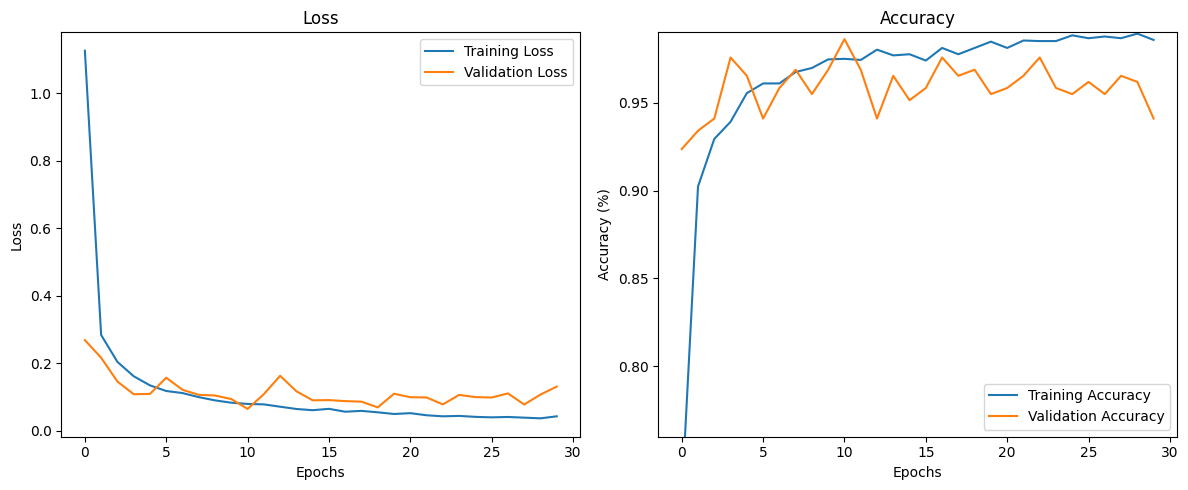

In [ ]:
plot_loss_curves(history)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import tensorflow as tf

# Assuming you have a trained model and test_dataset
# You need to get the true labels and predicted labels from the test set

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  # Assuming labels are in a tensor format
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert softmax outputs to class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the classification report (precision, recall, F1-score)
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

# Calculate accuracy using sklearn
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.9630 - loss: 0.0809
Test Loss: 0.09952948242425919
Test Accuracy: 0.957317054271698
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Confusion Matrix:
[[149   0   0   0]
 [  0  52   0  14]
 [  0   0 153   0]
 [  0   9   0 115]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       149
           1 

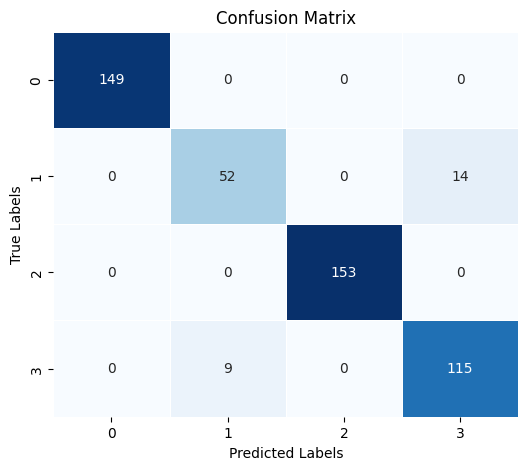

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define new confusion matrix
conf_matrix = np.array([[149, 0, 0, 0],
                        [0, 52, 0, 14],
                        [0, 0, 153, 0],
                        [0, 9, 0, 115]])

# Create heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()


# **RESNET**

In [ ]:
for images, labels in train_dataset.take(1):
    print("Image shape:", images.shape)  # Should be (BATCH_SIZE, 224, 224, 3)
    print("Label shape:", labels.shape)  # Should be (BATCH_SIZE,)


Image shape: (32, 256, 256, 3)
Label shape: (32,)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
import tensorflow as tf

# Input shape
input_shape = (256, 256, 3)

# Load ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
#base_model.trainable = False

# Custom classifier
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(4, activation='softmax')(x)  # 4 classes in your dataset

# Define the final model
model = Model(inputs=base_model.input, outputs=x)

# Model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,114,308 (91.99 MB)

 Trainable params: 24,060,676 (91.78 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [ ]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
for images, labels in train_dataset.take(1):
    print("Image shape:", images.shape)  # Expected: (BATCH_SIZE, 224, 224, 3)
    print("Label shape:", labels.shape)   # Expected: (BATCH_SIZE,) for sparse_categorical_crossentropy

# Train the model
try:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        verbose=1
    )
except Exception as e:
    print("Error during training:", e)

Image shape: (32, 256, 256, 3)
Label shape: (32,)
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 417ms/step - accuracy: 0.9512 - loss: 0.1331 - val_accuracy: 0.8090 - val_loss: 1.4418
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 379ms/step - accuracy: 0.9517 - loss: 0.1419 - val_accuracy: 0.6493 - val_loss: 3.5130
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 380ms/step - accuracy: 0.9565 - loss: 0.1208 - val_accuracy: 0.9514 - val_loss: 0.1357
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 37s 380ms/step - accuracy: 0.9679 - loss: 0.0851 - val_accuracy: 0.6840 - val_loss: 1.9820
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 379ms/step - accuracy: 0.9742 - loss: 0.0706 - val_accuracy: 0.9583 - val_loss: 0.1440
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 379ms/step - accuracy: 0.9729 - loss: 0.0834 - val_accuracy: 0.9375 - val_loss: 0.1498
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 37s 381ms/step - accuracy: 0.9812 - loss: 0.0545 - val_accuracy: 0.7431 - val_loss: 2.7417
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 380ms

In [ ]:
model.evaluate(test_dataset)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 318ms/step - accuracy: 0.9378 - loss: 0.2053


[0.1797276884317398, 0.9410569071769714]

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    # Plot loss
    plt.figure(figsize=(12, 5))  # Optional: Set figure size
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')

    # Set y-axis limits for accuracy plot
    plt.ylim(0.76, 0.99)  # Set limits from 76 to 99

    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

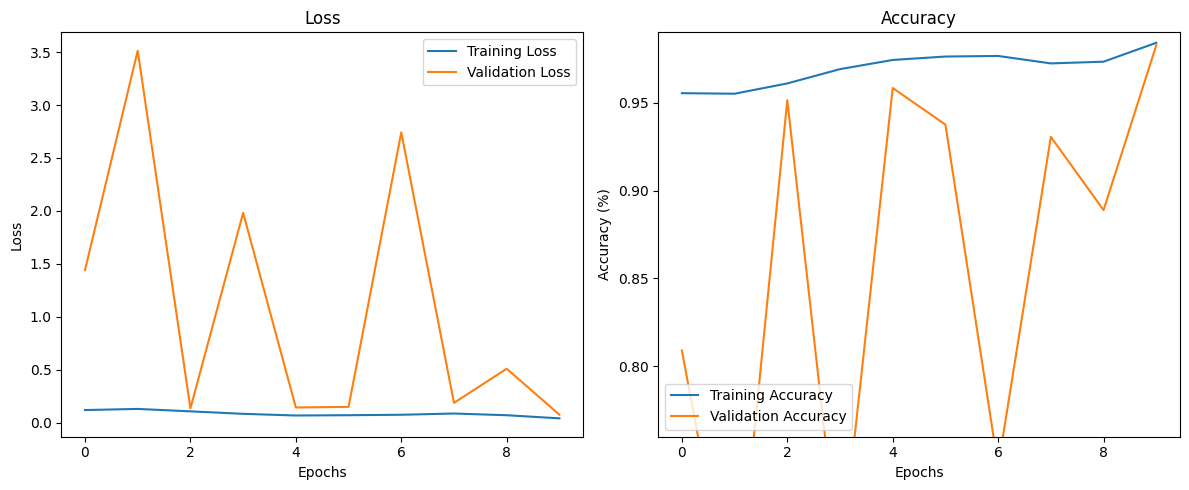

In [ ]:
plot_loss_curves(history)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import tensorflow as tf

# Assuming you have a trained model and test_dataset
# You need to get the true labels and predicted labels from the test set

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  # Assuming labels are in a tensor format
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert softmax outputs to class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the classification report (precision, recall, F1-score)
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

# Calculate accuracy using sklearn
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9499 - loss: 0.1627 
Test Loss: 0.15267907083034515
Test Accuracy: 0.9451219439506531
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Confusion Matrix:
[[155   0   1  10]
 [  0  57   0  10]
 [  0   0 130   0]
 [  0   6   2 121]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       166
           1   

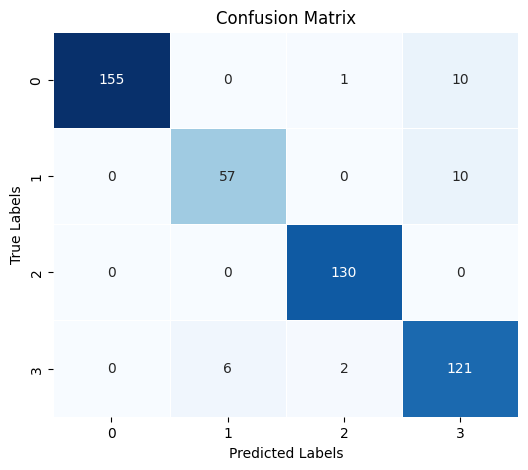

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the updated confusion matrix
conf_matrix = np.array([[155, 0, 1, 10],
                        [0, 57, 0, 10],
                        [0, 0, 130, 0],
                        [0, 6, 2, 121]])

# Create heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()


# **DenseNet121**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

input_layer = layers.Input(shape=(256, 256, 3), name="input")

# Data Augmentation
augmented = data_augmentation(input_layer)

base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=augmented)
base_model.trainable = False  # Unfreeze later for fine-tuning

#Custom Layers
x = layers.BatchNormalization()(base_model.output)
x = layers.ReLU()(x)
x = layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)  # L2 Regularization
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)  # 40% Dropout for Regularization
output_layer = layers.Dense(4, activation='softmax')(x)  # 4 Classes

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 256, 256, 3)    │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ sequential_2[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)        

 Total params: 9,402,180 (35.87 MB)

 Trainable params: 2,362,628 (9.01 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [ ]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
for images, labels in train_dataset.take(1):
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)   # Expected: (BATCH_SIZE,) for sparse_categorical_crossentropy

# Train the model
try:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        verbose=1
    )
except Exception as e:
    print("Error during training:", e)

Image shape: (32, 256, 256, 3)
Label shape: (32,)
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 284ms/step - accuracy: 0.7584 - loss: 2.1954 - val_accuracy: 0.8368 - val_loss: 1.2649
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.9176 - loss: 0.7129 - val_accuracy: 0.9167 - val_loss: 0.5988
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.9281 - loss: 0.5546 - val_accuracy: 0.7847 - val_loss: 1.2260
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.9164 - loss: 0.6306 - val_accuracy: 0.8993 - val_loss: 0.5452
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.9427 - loss: 0.4351 - val_accuracy: 0.9410 - val_loss: 0.3757
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.9324 - loss: 0.4332 - val_accuracy: 0.9097 - val_loss: 0.4298
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.9360 - loss: 0.3900 - val_accuracy: 0.9375 - val_loss: 0.4490
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms

In [ ]:
model.evaluate(test_dataset)


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.9103 - loss: 0.3443


[0.29761457443237305, 0.9288617968559265]

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    # Plot loss
    plt.figure(figsize=(12, 5))  # Optional: Set figure size
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')

    # Set y-axis limits for accuracy plot
    plt.ylim(0.76, 0.99)  # Set limits from 76 to 99

    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

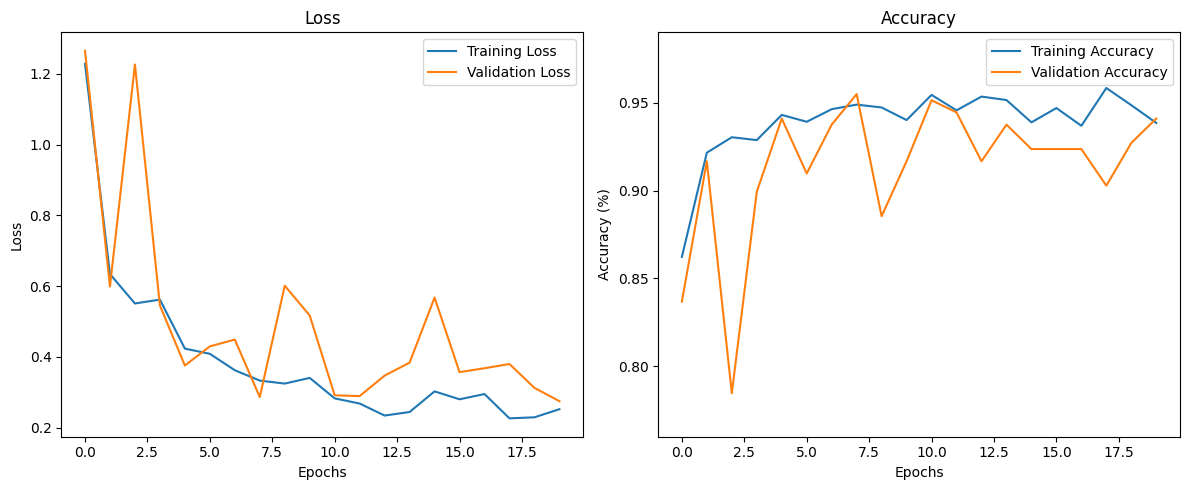

In [ ]:
plot_loss_curves(history)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import tensorflow as tf

# Assuming you have a trained model and test_dataset
# You need to get the true labels and predicted labels from the test set

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  # Assuming labels are in a tensor format
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert softmax outputs to class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the classification report (precision, recall, F1-score)
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

# Calculate accuracy using sklearn
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.9415 - loss: 0.2796
Test Loss: 0.2975353002548218
Test Accuracy: 0.9308943152427673
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix:
[[165   2   0   1]
 [  0  41   0  24]
 [  1   1 137   0]
 [  0   5   0 115]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       168
           1    

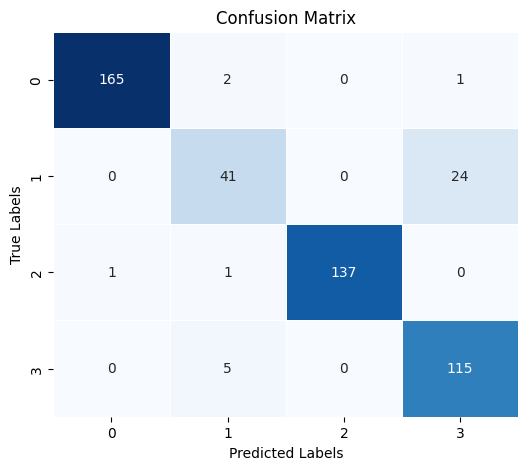

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the updated confusion matrix
conf_matrix = np.array([[165, 2, 0, 1],
                        [0, 41, 0, 24],
                        [1, 1, 137, 0],
                        [0, 5, 0, 115]])

# Create heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()


# **MobileNetV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for training set
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotate images by 20 degrees
    width_shift_range=0.2,  # Shift width by 20%
    height_shift_range=0.2,  # Shift height by 20%
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flipping
    fill_mode='nearest'  # Fill missing pixels
)

# Input layer
input_layer = layers.Input(shape=(256, 256, 3), name="input")

# Load MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze the base model for initial training
base_model.trainable = False

# Custom classification layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Prevent overfitting
output_layer = layers.Dense(4, activation='softmax')(x)  # 4 classes

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


<ipython-input-43-d57d8e6a2b76>:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.7950 - loss: 0.4911 - val_accuracy: 0.8958 - val_loss: 0.2318
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8869 - loss: 0.2440 - val_accuracy: 0.9167 - val_loss: 0.2249
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9078 - loss: 0.1981 - val_accuracy: 0.9097 - val_loss: 0.1917
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9139 - loss: 0.1884 - val_accuracy: 0.8715 - val_loss: 0.2785
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9117 - loss: 0.1906 - val_accuracy: 0.9236 - val_loss: 0.1897
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9230 - loss: 0.1788 - val_accuracy: 0.9028 - val_loss: 0.1809
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9341 - loss: 0.1535 - val_accuracy: 0.8958 - val_loss: 0.2556
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9186 - loss: 0.1645 - val_accuracy: 0.8993 - 

In [ ]:
model.evaluate(test_dataset)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.9397 - loss: 0.1519


[0.17131303250789642, 0.9308943152427673]

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    # Plot loss
    plt.figure(figsize=(12, 5))  # Optional: Set figure size
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')

    # Set y-axis limits for accuracy plot
    plt.ylim(0.76, 0.99)  # Set limits from 76 to 99

    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

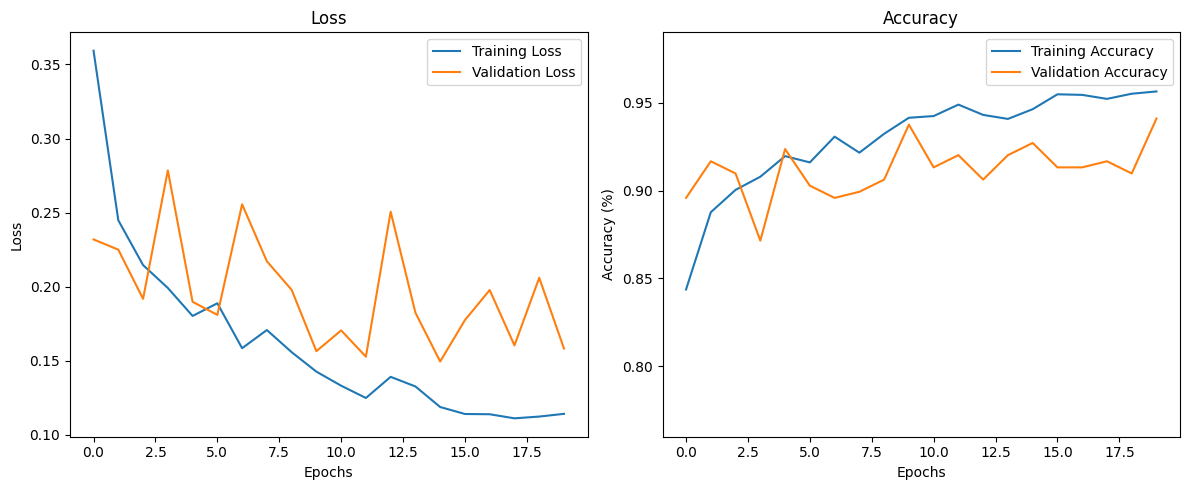

In [ ]:
plot_loss_curves(history)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import tensorflow as tf

# Assuming you have a trained model and test_dataset
# You need to get the true labels and predicted labels from the test set

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  # Assuming labels are in a tensor format
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert softmax outputs to class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the classification report (precision, recall, F1-score)
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

# Calculate accuracy using sklearn
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9405 - loss: 0.1809
Test Loss: 0.18099811673164368
Test Accuracy: 0.934959352016449
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix:
[[163   0   0   0]
 [  0  45   0  18]
 [  0   0 141   0]
 [  0  15   1 109]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       163
           1       0.75      0.

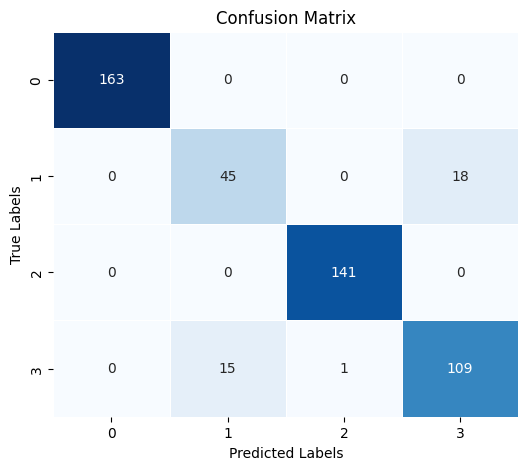

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the updated confusion matrix
conf_matrix = np.array([[163, 0, 0, 0],
                        [0, 45, 0, 18],
                        [0, 0, 141, 0],
                        [0, 15, 1, 109]])

# Create heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()


# **InceptionV3**

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Input Layer
input_layer = layers.Input(shape=(256, 256, 3), name="input")
x = data_augmentation(input_layer)  # Apply Data Augmentation

# Load InceptionV3 without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)

# Freeze the base model (optional)
#base_model.trainable = False

# Custom classification layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout to prevent overfitting
output_layer = layers.Dense(4, activation='softmax')(x)  # 4-class classification

# Create Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 256, 256, 3)    │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 127, 127, 32)   │            864 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 127, 127, 32)   │             96 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 127, 127, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 125, 125, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_98    │ (None, 125, 125, 32)   │             96 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 125, 125, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 125, 125, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_99    │ (None, 125, 125, 64)   │            192 │ conv2d_98[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 125, 125, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 62, 62, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_100   │ (None, 62, 62, 80)     │            240 │ conv2d_99[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 62, 62, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 22,293,924 (85.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 100s 528ms/step - accuracy: 0.8223 - loss: 0.4611 - val_accuracy: 0.3090 - val_loss: 237.7664
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 483ms/step - accuracy: 0.9441 - loss: 0.1799 - val_accuracy: 0.9132 - val_loss: 0.2061
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 483ms/step - accuracy: 0.9507 - loss: 0.1477 - val_accuracy: 0.9201 - val_loss: 0.4451
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 483ms/step - accuracy: 0.9667 - loss: 0.0924 - val_accuracy: 0.8958 - val_loss: 0.2791
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 478ms/step - accuracy: 0.9617 - loss: 0.1169 - val_accuracy: 0.8438 - val_loss: 1.0295
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 481ms/step - accuracy: 0.9568 - loss: 0.1254 - val_accuracy: 0.9201 - val_loss: 0.2594
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 479ms/step - accuracy: 0.9578 - loss: 0.1213 - val_accuracy: 0.9653 - val_loss: 0.1138
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 482ms/step - accuracy: 0.9790 - loss: 0.0719 - val_a

In [ ]:
model.evaluate(test_dataset)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.9662 - loss: 0.1283


[0.11765917390584946, 0.9613820910453796]

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    # Plot loss
    plt.figure(figsize=(12, 5))  # Optional: Set figure size
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')

    # Set y-axis limits for accuracy plot
    plt.ylim(0.76, 0.99)  # Set limits from 76 to 99

    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

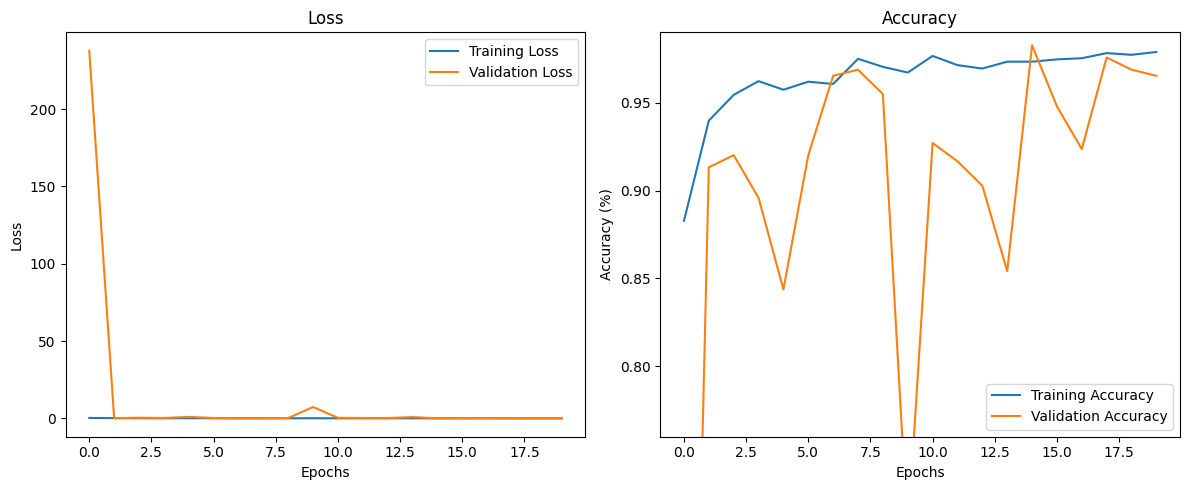

In [ ]:
plot_loss_curves(history)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import tensorflow as tf

# Assuming you have a trained model and test_dataset
# You need to get the true labels and predicted labels from the test set

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  # Assuming labels are in a tensor format
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert softmax outputs to class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the classification report (precision, recall, F1-score)
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

# Calculate accuracy using sklearn
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9468 - loss: 0.1699
Test Loss: 0.11166415363550186
Test Accuracy: 0.9593495726585388
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Confusion Matrix:
[[177   1   0   0]
 [  0  55   0   8]
 [  0   0 133   0]
 [  0  10   0 108]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       178
           1   

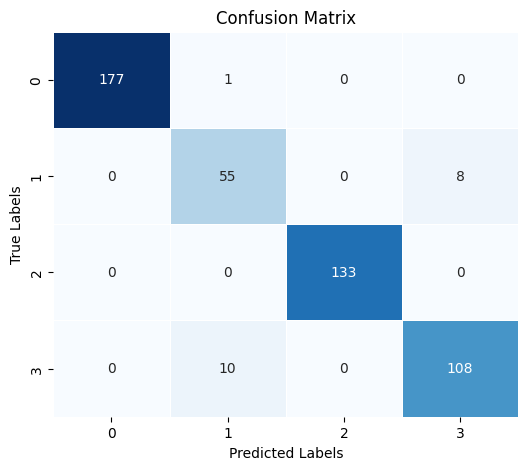

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the updated confusion matrix
conf_matrix = np.array([[177, 1, 0, 0],
                        [0, 55, 0, 8],
                        [0, 0, 133, 0],
                        [0, 10, 0, 108]])

# Create heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()
